In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sys
%matplotlib inline
from src import utils

## Questions
<ol>
 <li>Which neighbourhoods are most frequented?</li>
 <li>What influences the price rental price?</li>
 <li> What about economy due to COVID-19 quarantine? 
</li>
</ol>

Future works:
<ol>
<li> Satisfation in a review is about perfection or surprise? Sentimental analysis in reviews text
<li> Analysis in prob to rent places
</ol>

# Load Datasets

In [93]:
# Calendar of next books since 25/10/2020
calendar = pd.read_csv('data/raw/calendar.csv')

# List of places registered in Airbnb Rio
listings = pd.read_csv('data/raw/listings.csv')

# Reviews registered
reviews = pd.read_csv('data/raw/reviews.csv')

# List of neighbourhoods
nb = pd.read_csv('data/raw/neighbourhoods.csv')

# Summary of places registered in Airbnb RIO
lists = pd.read_csv('data/raw/listings_summary.csv')

# Summary of reviews registered
revs = pd.read_csv('data/raw/reviews_summary.csv')

# Info geospatial about Rio
df_places = gpd.read_file('data/raw/neighbourhoods.geojson')

# Filter from listings inative hosts

In [94]:
listings_filtered = utils.calc_delta_day(listings, 'last_review')

- Filter only hosts who has at least 1 review last 6 months

In [95]:
listings_filtered = listings_filtered[listings_filtered.delta_last_review <= 180]

# 1. Which neighbourhoods are most frequented?

In [96]:
count_revs = revs[revs.date >= '2020-04-25'].groupby('listing_id').count().reset_index()

In [97]:
count_revs.columns = ['id', 'count_reviews']

In [98]:
neighbourhood = lists[['id', 'neighbourhood']].copy()

In [99]:
df_neighbourhood = neighbourhood.merge(count_revs, how='inner', on='id')

In [100]:
count_neighbourhood = df_neighbourhood.groupby('neighbourhood')['count_reviews'].sum().sort_values(ascending=False)

In [101]:
total_reviews = df_neighbourhood['count_reviews'].sum()

In [102]:
result_1 = (count_neighbourhood/total_reviews).head(5)
result_1

neighbourhood
Copacabana                  0.322579
Barra da Tijuca             0.136690
Ipanema                     0.106148
Leblon                      0.060738
Recreio dos Bandeirantes    0.057696
Name: count_reviews, dtype: float64

They are top frequented neighbourhoods

In [105]:
plt.rcParams["figure.figsize"] = (12,5)

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

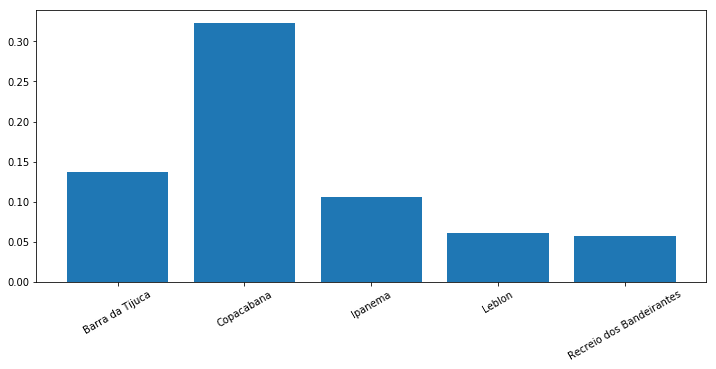

In [106]:
plt.bar(result_1.reset_index().neighbourhood.values, result_1.reset_index().count_reviews.values)
plt.xticks(rotation=30)

- Places available in the list

In [124]:
result_2 = df_neighbourhood.neighbourhood.value_counts(normalize=True).head(5)

In [122]:
result_2.reset_index()

,index,neighbourhood
0,Copacabana,0.332970
1,Barra da Tijuca,0.130312
2,Ipanema,0.122685
3,Leblon,0.061669
4,Recreio dos Bandeirantes,0.045108


- plot map

In [108]:
# Create flag top_neighbourhoods
df_places.loc[df_places.neighbourhood.isin(list(result_1.index)), 'top_neighbourhood'] = 1
df_places.top_neighbourhood.fillna(0, inplace=True)

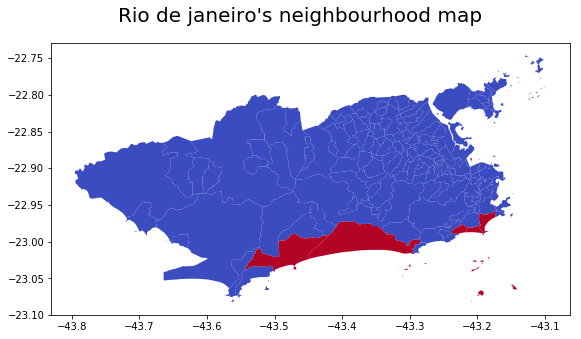

In [109]:
plot = df_places.plot(column='top_neighbourhood', cmap='coolwarm')
fig = plot.get_figure()
fig.suptitle(r"Rio de janeiro's neighbourhood map", fontsize=20)
fig.savefig('figures/neighbourhood_map.png', dpi=600, transparent=False)

# 2. Which elements influence the price?</li>

- Drop outliers in price

In [20]:
listings_filtered = listings_filtered[listings_filtered.price.apply(lambda x: len(x)) != 10]

- DROP 4 NAN listings reviews in specific categories

In [21]:
listings_filtered  = listings_filtered [~listings_filtered .review_scores_accuracy.isnull()]

In [22]:
listings_filtered .reset_index(drop=True, inplace=True)

# Data Prep

In [23]:
num_cols = [
    'host_since', 'host_response_rate', 'host_acceptance_rate', 'accommodates',
    'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30',
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
    'last_review', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month', 'price'
    ]

In [24]:
df_num = listings_filtered[num_cols].copy()

In [25]:
df_num.head()

,host_since,host_response_rate,host_acceptance_rate,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price
0,2010-01-08,100%,100%,5,2.0,2.0,5,180,0,0,...,2020-10-13,93.0,9.0,9.0,10.0,10.0,10.0,9.0,2.04,$134.00
1,2010-06-27,93%,95%,2,1.0,1.0,3,15,4,15,...,2020-10-20,98.0,10.0,10.0,10.0,10.0,10.0,10.0,2.77,$135.00
2,2010-01-16,95%,94%,13,6.0,6.0,2,89,11,33,...,2020-10-12,92.0,9.0,9.0,10.0,10.0,10.0,9.0,0.80,"$1,339.00"
3,2010-09-05,99%,99%,3,1.0,1.0,3,90,11,13,...,2020-10-13,94.0,9.0,9.0,10.0,10.0,10.0,9.0,0.89,$129.00
4,2010-01-16,95%,94%,6,3.0,3.0,3,89,11,33,...,2020-09-20,90.0,9.0,9.0,10.0,9.0,10.0,9.0,0.65,$569.00


In [26]:
# PREP numerical columns
df_num = utils.calc_delta_day(df_num, 'host_since', True)
df_num = utils.calc_delta_day(df_num, 'last_review', True)
df_num = utils.cast_pct_col(df_num, 'host_response_rate')
df_num = utils.cast_pct_col(df_num, 'host_acceptance_rate')
df_num = utils.cast_currency_col(df_num, 'price')

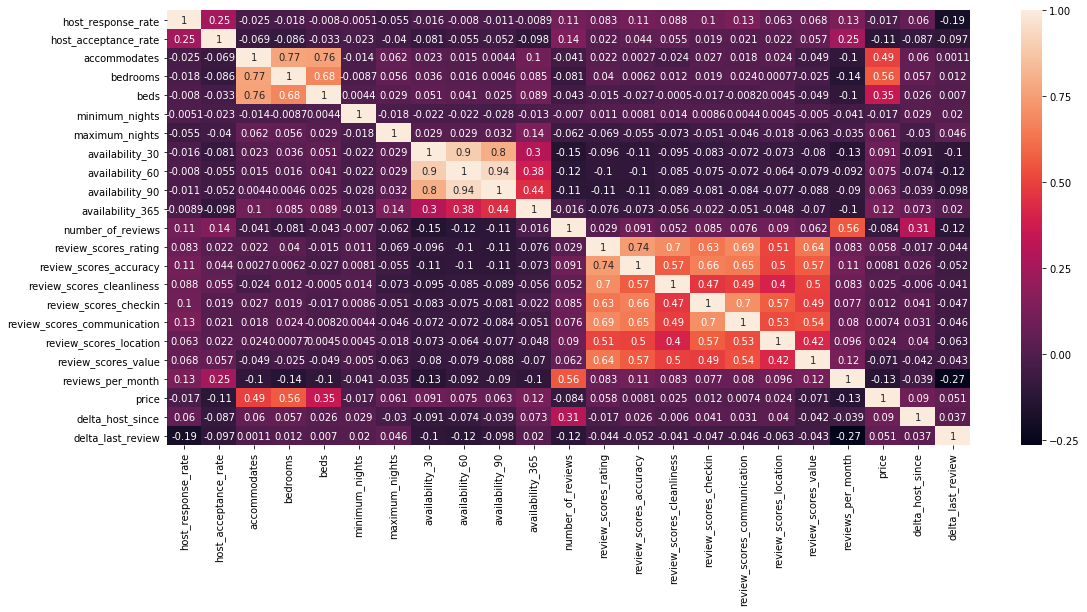

In [27]:
fig, ax = plt.subplots(figsize=(18, 8))
fig = sns.heatmap(ax=ax, data=df_num.corr(), annot=True)

# accomodates, bedrooms and bed are highly correlated with price

- Fill NAs

In [28]:
df_num.isnull().sum()

host_response_rate              62
host_acceptance_rate            35
accommodates                     0
bedrooms                       435
beds                            18
minimum_nights                   0
maximum_nights                   0
availability_30                  0
availability_60                  0
availability_90                  0
availability_365                 0
number_of_reviews                0
review_scores_rating             0
review_scores_accuracy           0
review_scores_cleanliness        0
review_scores_checkin            0
review_scores_communication      0
review_scores_location           0
review_scores_value              0
reviews_per_month                0
price                            0
delta_host_since                 0
delta_last_review                0
dtype: int64

- NAN bedrooms are studio type?

In [29]:
aux = listings[listings.bedrooms.isnull()][['accommodates', 'listing_url']]

In [30]:
aux.accommodates.value_counts()

2     601
4     447
3     299
1      59
5      55
6      36
16      8
8       8
10      7
15      4
7       3
13      1
12      1
0       1
Name: accommodates, dtype: int64

In [31]:
aux[aux.accommodates == 16]

,accommodates,listing_url
5450,16,https://www.airbnb.com/rooms/10407056
12828,16,https://www.airbnb.com/rooms/22779331
13192,16,https://www.airbnb.com/rooms/23644123
13194,16,https://www.airbnb.com/rooms/23644849
13808,16,https://www.airbnb.com/rooms/27429420
14272,16,https://www.airbnb.com/rooms/29418477
14392,16,https://www.airbnb.com/rooms/29773328
14455,16,https://www.airbnb.com/rooms/29909483


Conclusion: Yes, or places to only rent to make a party

In [32]:
fill_zero = ['bedrooms', 'beds']
fill_mean = ['host_response_rate', 'host_acceptance_rate']

df_num.loc[:, fill_zero] = df_num[fill_zero].fillna(0)
df_num.loc[:, fill_mean] = df_num[fill_mean].fillna(df_num[fill_mean].mean())

In [33]:
df_num.isnull().sum().sum()
# Nan problems solved

0

- Train Test Split

In [34]:
X = df_num.drop('price', axis=1)
y = df_num.price

In [35]:
mae_train, mae_test, lmodel = utils.train_lmodel(X, y)

MAE train: 140.25
MAE test: 136.8


### Categorical Features

In [36]:
cat_cols = [
    'host_response_time', 'host_is_superhost', 'host_identity_verified',
    'neighbourhood_cleansed', 'room_type', 'amenities', 'instant_bookable'
    ]

In [37]:
df_cat = listings_filtered[cat_cols].copy()

In [38]:
df_cat.head()

,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,room_type,amenities,instant_bookable
0,within an hour,t,t,Copacabana,Entire home/apt,"[""Patio or balcony"", ""Dishes and silverware"", ...",t
1,within an hour,t,t,Copacabana,Entire home/apt,"[""Dishes and silverware"", ""Microwave"", ""Cookin...",f
2,within a day,f,t,Ipanema,Entire home/apt,"[""Patio or balcony"", ""Dishes and silverware"", ...",f
3,within an hour,t,t,Copacabana,Entire home/apt,"[""Dishes and silverware"", ""Ceiling fan"", ""Micr...",t
4,within a day,f,t,Ipanema,Entire home/apt,"[""Bathroom essentials"", ""Fire extinguisher"", ""...",f


In [39]:
df_cat = utils.cast_bool(df_cat, 'host_is_superhost')
df_cat = utils.cast_bool(df_cat, 'host_identity_verified')
df_cat = utils.cast_bool(df_cat,'instant_bookable')
df_cat = utils.flag_room_type(df_cat, 'room_type', True)
df_cat = utils.create_dummies(df_cat, 'host_response_time')
df_cat = utils.create_dummies(df_cat, 'neighbourhood_cleansed')

In [40]:
df_cat, mlb = utils.processes_mlb(df_cat, 'amenities', True)

In [41]:
# Putting together num and cat columns
df_final = df_num.join(df_cat)

X = df_final.drop('price', axis=1)
y = df_final.price

In [42]:
mae_train_cat, mae_test_cat, lmodel_cat = utils.train_lmodel(X, y)

MAE train: 128.89
MAE test: 2281653074503436.0


Observation: Overfit due to too many features!

### Feature Selection

In [43]:
# Create list of possible cuts to vary in minimun percentage
# of positive class distribution in each columns
cuts = list(np.array(range(500, 1, -1))/500)

In [44]:
mae_trains, mae_tests, num_feats, best_model, reduce_x = utils.select_features(X, y, cuts)

MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.25
MAE test: 136.8
MAE train: 140.16
MAE test: 136.77
MAE train: 140.16
MAE test: 136.77
MAE train: 140.16
MAE test: 136.77
MAE train: 140.16
MAE test: 136.77
MAE train: 140.16
MAE test: 136.77
MAE train: 140.16
MAE test: 136.77
MAE trai

MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.66
MAE test: 138.53
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.52
MAE test: 138.56
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MAE test: 138.43
MAE train: 138.53
MA

MAE train: 131.43
MAE test: 130.78
MAE train: 131.41
MAE test: 130.73
MAE train: 131.4
MAE test: 130.83
MAE train: 131.4
MAE test: 130.83
MAE train: 131.41
MAE test: 130.57
MAE train: 131.41
MAE test: 130.57
MAE train: 131.4
MAE test: 130.41
MAE train: 130.89
MAE test: 130.6
MAE train: 130.89
MAE test: 130.58
MAE train: 130.89
MAE test: 130.32
MAE train: 130.96
MAE test: 130.23
MAE train: 131.16
MAE test: 130.38
MAE train: 130.67
MAE test: 129.93
MAE train: 130.49
MAE test: 130.13
MAE train: 130.59
MAE test: 130.82
MAE train: 130.62
MAE test: 131.4
MAE train: 130.51
MAE test: 131.57
MAE train: 130.53
MAE test: 131.34
MAE train: 130.53
MAE test: 131.34
MAE train: 130.51
MAE test: 131.55
MAE train: 130.36
MAE test: 130.91
MAE train: 128.8
MAE test: 131.87
MAE train: 130.67
MAE test: 129.93
129.9307311462323


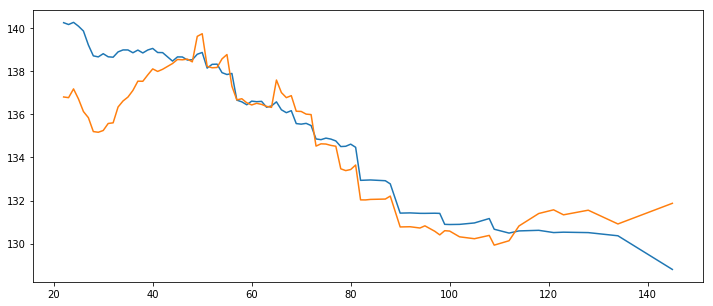

In [45]:
plt.plot(num_feats, mae_trains)
plt.plot(num_feats, mae_tests.values())

In [46]:
cols = list(reduce_x.columns)
feature_importance = pd.DataFrame(best_model.coef_, index=list(reduce_x.columns))
feature_importance.columns = ['feature_importance']

In [47]:
# High positive importance features
feature_importance.sort_values(by='feature_importance', ascending=False).head(10)

,feature_importance
amenities_Pool,175.007646
amenities_Dishwasher,159.383225
amenities_Bathtub,135.294671
neighbourhood_cleansed_Leblon,116.521688
bedrooms,115.617628
neighbourhood_cleansed_Ipanema,103.204649
amenities_Dryer,65.067311
amenities_Hot tub,64.954320
neighbourhood_cleansed_Copacabana,62.599226
flag_entire_home,56.189341


In [48]:
# High negative importance features
feature_importance.sort_values(by='feature_importance').head(5)

,feature_importance
amenities_Gym,-110.882995
neighbourhood_cleansed_Jacarepaguá,-74.758062
amenities_Children’s books and toys,-49.719355
amenities_Children’s dinnerware,-47.919992
amenities_Washer,-40.499488


# 3. What about economy due to COVID-19 quarantine?

In [49]:
# Filter always same period in each year
reviews_2020 = revs[revs.date >= '2020-01-01'].copy()
reviews_2019 = revs[(revs.date >= '2019-01-01') & (revs.date <= '2019-10-25')]
reviews_2018 = revs[(revs.date >= '2018-01-01') & (revs.date <= '2018-10-25')]
reviews_2017 = revs[(revs.date >= '2017-01-01') & (revs.date <= '2017-10-25')]
reviews_2016 = revs[(revs.date >= '2016-01-01') & (revs.date <= '2016-10-25')]

In [50]:
reviews_2020 = utils.create_month(reviews_2020, 'date')
reviews_2019 = utils.create_month(reviews_2019, 'date')
reviews_2018 = utils.create_month(reviews_2018, 'date')
reviews_2017 = utils.create_month(reviews_2017, 'date')
reviews_2016 = utils.create_month(reviews_2016, 'date')

In [51]:
count_reviews_2020 = utils.count_reviews(reviews_2020, 'month', 2020)
count_reviews_2019 = utils.count_reviews(reviews_2019, 'month', 2019)
count_reviews_2018 = utils.count_reviews(reviews_2018, 'month', 2018)
count_reviews_2017 = utils.count_reviews(reviews_2017, 'month', 2017)
count_reviews_2016 = utils.count_reviews(reviews_2016, 'month', 2016)

In [52]:
count_concat = pd.concat([count_reviews_2020,
                          count_reviews_2019,
                          count_reviews_2018,
                          count_reviews_2017,
                          count_reviews_2016])

In [53]:
count_concat.groupby('year').counts.sum()

year
2016    25022
2017    32569
2018    39036
2019    72063
2020    51572
Name: counts, dtype: int64

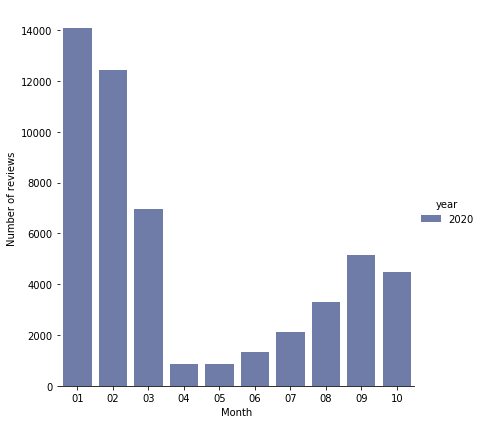

In [54]:
g = sns.catplot(
    data=count_reviews_2020, kind="bar",
    x="month", y="counts", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Month", "Number of reviews")

In [55]:
result_sec_tri = utils.compare_tri(count_reviews_2019, count_reviews_2020, ['04', '05', '06'])
msg = """In 2020 second trimester, the number of reviews reduced {}% over same period in 2019.""".format(result_sec_tri)
print(msg)

In 2020 second trimester, the number of reviews reduced 82.21% over same period in 2019.


In [56]:
result_sec_tri = utils.compare_tri(count_reviews_2019, count_reviews_2020, ['07', '08', '09'])
msg = """In 2020 third trimester, the number of reviews reduced {}% over same period in 2019.""".format(result_sec_tri)
print(msg)

In 2020 third trimester, the number of reviews reduced 49.26% over same period in 2019.


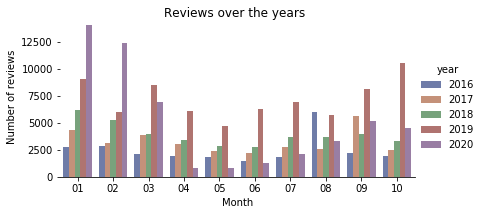

In [69]:
#fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.catplot(
                data=count_concat,
                kind="bar",
                x="month",
                y="counts",
                hue="year",
                ci="sd",
                palette="dark",
                alpha=.6,
                height=3,
                aspect=12/6
)
g.despine(left=True)
g.fig.suptitle('Reviews over the years')
g.set_axis_labels("Month", "Number of reviews")
g.savefig("figures/history_num_reviews.png", dpi=600, transparent=True)

Airbnb shows a growth over the years, including beginning of 2020 in janurary and februrary. However, COVID-19's 
phenomenon impacts hardly the services. In Brazil, quarantine started 24/03/2020. During second trimester of 2020, 
reviews numbers in RIO decreased 82% and third trimester 49% both compared with 2019 in same period. The flow is
getting better but it yet is really far from growth before COVID-19.

### Check specific months in years that are outliars for annual growth behavior

- Aug/2016

In August of 2016, Brazil hosted Olympic Games

- sep/2017

In [ ]:
reviews_2017_sep = reviews_2017[reviews_2017.month == '09']
count_days_2017_sep = utils.count_reviews(reviews_2017_sep, 'date', 2017)
count_days_2017_sep['day'] = count_days_2017_sep.date.str.split('-').apply(lambda x: x[2])

In [ ]:
g = sns.catplot(
    data=count_days_2017_sep, kind="bar",
    x="day", y="counts", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("Month", "Number of reviews")
g.legend.set_title("")

During 15, 16, 17, 21, 22, 23 and 24 on september in 2017, 
happened Rock in Rio, one of the biggest music festival in the world. Apparentely, the lineup in that specif year was really good, because reviews after these days increased heavily.